### Simple Hopfield Network

In [1]:
import utils

import numpy as np
import jax
import jax.numpy as jnp
from jax import random as jrandom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

Load a few mnist data.

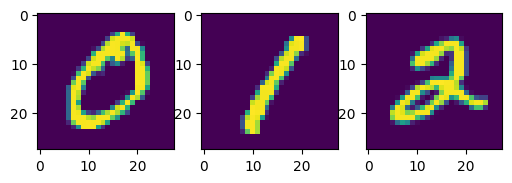

In [2]:
path_ = "/home/ben/Documents/data/MNIST/raw"
x_train, y_train, _, _ = utils.get_mnist_data(path_)
data = []
plt.figure(figsize=(6, 4))
for idx, i in enumerate(range(0, 3)):
    xi = x_train[y_train==i]
    data.append(xi[0])
    plt.subplot(1, 3, idx+1)
    plt.imshow(data[-1])
plt.show()

Since we are focusing on the hopfield architecture, we simplfy data input network/shape by flattening it.

In [3]:
from skimage.filters import threshold_mean

def process(img):
    w, h = img.shape
    # Thresholding
    th = threshold_mean(img)
    binary = img > th
    shift = 2*(binary*1)-1 # Boolian to int
    
    # Reshape
    flatten_data = jnp.reshape(shift, (w*h))
    return flatten_data

data = [process(d) for d in data]
data[0].shape

(784,)

We use a simple hebbian rule to train the hopfield network!

In [4]:
class HopfieldNetwork():
    def __init__(self, input_data):
        self.num_neuron = input_data[0].shape[0]
        self.data_count = len(input_data)
        self.W = jnp.zeros((self.num_neuron, self.num_neuron))
        self.rho = jnp.sum(jnp.asarray([jnp.sum(t) for t in input_data])) / (self.data_count*self.num_neuron)
        self.data = input_data

    def train(self):
        # Hebbian rule
        for i in range(self.data_count):
            t = self.data[i] - self.rho
            self.W += jnp.outer(t, t)

        # Neurons cannot connect to self, set value=0
        diagW = jnp.diag(jnp.diag(self.W))
        self.W = self.W - diagW
        self.W /= self.data_count

In [5]:
hnn = HopfieldNetwork(data)
hnn.train()

Display the learned weights

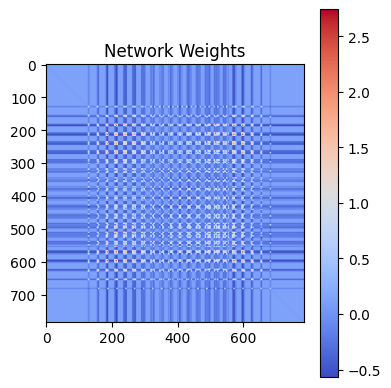

In [6]:
plt.figure(figsize=(4, 4))
w_mat = plt.imshow(hnn.W, cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.show()

Let us test the hopfield network. We start by preparing a corrupted set of data.

In [7]:
def corrupt_data(input, degree_of_corruption):
    corrupted_data = np.copy(input)
    inv = np.random.binomial(n=1, p=degree_of_corruption, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted_data[i] = -1 * v
    return jnp.asarray(corrupted_data)

data_test = [corrupt_data(d, 0.2) for d in data]

Let us add the prediction code to the network.

In [8]:
class HopfieldNetwork():
    def __init__(self, input_data, num_iterations=15, threshold=0):
        self.num_neuron = input_data[0].shape[0]
        self.data_count = len(input_data)
        self.W = jnp.zeros((self.num_neuron, self.num_neuron))
        self.rho = jnp.sum(jnp.asarray([jnp.sum(t) for t in input_data])) / (self.data_count*self.num_neuron)
        self.data = input_data

        self.num_iterations = num_iterations
        self.threshold = threshold

    def train(self):
        # Hebbian rule
        for i in range(self.data_count):
            t = self.data[i] - self.rho
            self.W += jnp.outer(t, t)

        # Neurons cannot connect to self, set value=0
        diagW = jnp.diag(jnp.diag(self.W))
        self.W = self.W - diagW
        self.W /= self.data_count

    def predict(self, data):
        data_ = jnp.copy(jnp.asarray(data))
        
        predicted = []
        for i in range(len(data)):
            # Get initial energy state
            s = data_[i]
            e = self.energy_fn(s)

            for i in range(self.num_iterations):
                # Update s
                s = jnp.sign(self.W @ s - self.threshold)
                # Calculate new energy state
                e_new = self.energy_fn(s)
                
                if e == e_new:
                    # Stop if s converged
                    break

                # Update energy
                e = e_new
            
            predicted.append(s)
        return predicted

    def energy_fn(self, s):
        return -0.5 * s @ self.W @ s + jnp.sum(s * self.threshold)

Run some predictions.

In [9]:
hnn = HopfieldNetwork(data, num_iterations=20, threshold=50)
hnn.train()
pred = hnn.predict(data_test)

Testing the model.

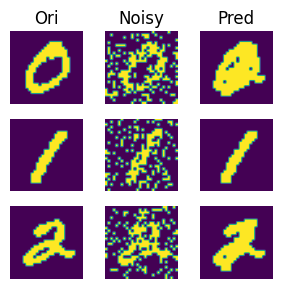

In [12]:
data_ori = [utils.reshape(d) for d in data]
data_test_ = [utils.reshape(d) for d in data_test]
data_pred = [utils.reshape(d) for d in pred]

fig, ax = plt.subplots(len(data), 3, figsize=(3,3))
for i in range(len(data)):
    if i==0:
        ax[i, 0].set_title('Ori')
        ax[i, 1].set_title("Noisy")
        ax[i, 2].set_title('Pred')
        
    ax[i, 0].imshow(data_ori[i])
    ax[i, 0].axis('off')
    ax[i, 1].imshow(data_test_[i])
    ax[i, 1].axis('off')
    ax[i, 2].imshow(data_pred[i])
    ax[i, 2].axis('off')
        
plt.tight_layout()
plt.show()